# Load Model From Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initialize Paths of Models and Parameters

In [2]:
path= "/content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/models/"
# copy file that has helper function
!cp '/content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/test/helper/score.py' .
!cp '/content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/test/helper/scoreTest.py' .
!cp '/content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/utils/translate.py' .

model_list= ["1000","2908","5000","10000"]

# Install and Import Modules

In [3]:
!pip install -q "tensorflow==2.8.*"
!pip install -q "tensorflow-text==2.8.*"

     |████████████████████████████████| 497.9 MB 34 kB/s 
     |████████████████████████████████| 5.8 MB 45.1 MB/s 
     |████████████████████████████████| 462 kB 66.6 MB/s 
     |████████████████████████████████| 1.4 MB 58.1 MB/s 
     |████████████████████████████████| 4.9 MB 4.1 MB/s 


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import pickle
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM
from tensorflow.keras import layers , activations , models , preprocessing , utils
from tensorflow.keras.models import load_model
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
import tensorflow_text as text

In [5]:
from scoreTest import get_cosine_val, get_BLEU_score, get_ROUGE_score
from translate import  translate_sentence

In [6]:
!pip install fasttext
import fasttext.util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 2.8 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3161309 sha256=570166ae8bd64abb4370e3d85754a3611a4d0fb20d0eb5f1fb5c92adf2f9c96c
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


# Download Sentences for Test

In [7]:
!wget http://www.manythings.org/anki/hin-eng.zip -O hin-eng.zip
!unzip hin-eng.zip

--2022-10-19 16:46:23--  http://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131711 (129K) [application/zip]
Saving to: ‘hin-eng.zip’

hin-eng.zip         100%[===================>] 128.62K   268KB/s    in 0.5s    

2022-10-19 16:46:24 (268 KB/s) - ‘hin-eng.zip’ saved [131711/131711]

Archive:  hin-eng.zip
  inflating: hin.txt                 
  inflating: _about.txt              


# Def. Get Summary Statistics for every model 

In [23]:
def get_model_statistics_summary(model_path,path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary, encoderPath, decoderPath ):

################################## START  ##################################
    reconstructed_model = keras.models.load_model(model_path)
    plot_model(reconstructed_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)
    reconstructed_model.summary()


    ## Load Dictionaries and Parameters 
    path_encoder_parameters= path_encoder_parameters
    path_encoder_dictionary= path_encoder_dictionary
    path_decoder_parameters= path_decoder_parameters
    path_decoder_dictionary= path_decoder_dictionary

    # loading
    with open(path_encoder_parameters, 'rb') as handle:
        encoder_parameters = pickle.load(handle)

    # loading
    with open(path_encoder_dictionary, 'rb') as handle:
        encoder_dictionary = pickle.load(handle)

    # loading
    with open(path_decoder_parameters, 'rb') as handle:
        decoder_parameters= pickle.load(handle)

    # loading
    with open(path_decoder_dictionary, 'rb') as handle:
        decoder_dictionary = pickle.load(handle)    

    print(encoder_parameters)
    # encoder_dictionary
    print(decoder_parameters)
    # decoder_dictionary

    encoder_inputs = reconstructed_model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = reconstructed_model.layers[4].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)
    latent_dim = 256  # Note: may be need to save in drive as well


    num_decoder_tokens =decoder_parameters['num_decoder_tokens']
    max_output_length= decoder_parameters['max_decoder_seq_length']
    max_input_length= encoder_parameters['max_encoder_seq_length']

    encoder_word_dict=encoder_dictionary
    decoder_word_dict= decoder_dictionary


    decoder_inputs = Input(shape=( max_output_length , ))
    decoder_embedding = Embedding( num_decoder_tokens, 256 , mask_zero=True) (decoder_inputs)

    decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
    decoder_dense = Dense( num_decoder_tokens , activation=tf.keras.activations.softmax ) 


   

    def make_inference_models():
        
            encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
            
            decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
            decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
            
            decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
            
            decoder_outputs, state_h, state_c = decoder_lstm(
                decoder_embedding , initial_state=decoder_states_inputs)
            decoder_states = [state_h, state_c]
            decoder_outputs = decoder_dense(decoder_outputs)
            decoder_model = tf.keras.models.Model(
                [decoder_inputs] + decoder_states_inputs,
                [decoder_outputs] + decoder_states)
            
            return encoder_model , decoder_model


    enc_model , dec_model = make_inference_models()


    # Test Previous Model


    encoderPath= encoderPath
    decoderPath= decoderPath

    # loading

    enc_model =  load_model(encoderPath)
    dec_model  =  load_model(decoderPath)



################################## END  ##################################

    ## Get sentences to test the model

    lines = pd.read_table( 'hin.txt' , names=[ 'eng' , 'hindi' ] )
    lines.reset_index( level=0 , inplace=True )
    lines.rename( columns={ 'index' : 'eng' , 'eng' : 'hindi' , 'hindi' : 'c' } , inplace=True )
    lines = lines.drop( 'c' , 1 )  

    sample_sentences= lines[-10:]
    sample_sentences

    # Reference Token 

    reference_tokens=[]

    for line in sample_sentences['eng']:
        # print( line.split() ) 
        reference_tokens.append( line.split() )

    df = pd.DataFrame(      columns=['reference', 'candidate', 'bleu_score'],  )

    df["reference"]= reference_tokens

    ####### START Calculate Cosine Similarity for two sentences
    scores=[]
    for line in sample_sentences['eng']:
        translation= translate_sentence(line, enc_model,dec_model, encoder_word_dict,  decoder_word_dict , max_input_length, preprocessing)
        result= get_cosine_val (translation, line)
        scores.append(result)

    df["cosine_similarity"]= scores    ## Cosine score calculated

    ####### END Calculate Cosine Similarity for two sentences
    

    # Candidate Tokens 
    candidate_tokens=[]


    for line in sample_sentences['hindi']:
    
        result= translate_sentence(line, enc_model,dec_model, encoder_word_dict,  decoder_word_dict , max_input_length, preprocessing)
        temp =result.split()
        temp= temp[:-1]
        candidate_tokens.append(temp)
        

    df["candidate"]= candidate_tokens


    ## Calculate BLEU score

    scores=get_BLEU_score(df,sentence_bleu)
    df["bleu_score"]= scores    ## BLEU score calculated

    ## Calcualte ROUGE score
    scores= get_ROUGE_score(df, pd, tf,text)
    df["rouge_score"]= scores  ## ROUGE score calculated

    rouge_metric= pd.DataFrame.from_records(df['rouge_score'])

    average_f_measure = rouge_metric['f_measure'].mean()
    average_p_measure = rouge_metric['p_measure'].mean()
    average_r_measure = rouge_metric['r_measure'].mean()
    average_cosine= df['cosine_similarity'].mean()
    average_bleu= df['bleu_score'].mean()

    ## return BLEU and ROUGE score to the list 
    return [average_f_measure, average_p_measure,average_r_measure, average_cosine, average_bleu]

        

    

# Get Summary Statistics Table

In [24]:

stat=[]
for item in model_list:

    model_path= path+item+"/model.h5" 
    path_encoder_parameters= path+item+"/parameters/encoder_parameters.pickle" 
    path_encoder_dictionary= path+item+"/dictionaries/encoder_dictionary.pickle" 
    path_decoder_parameters= path+item+"/parameters/decoder_parameters.pickle" 
    path_decoder_dictionary= path+item+"/dictionaries/decoder_dictionary.pickle" 
    encoderPath= path+item+"/enc_model.h5" 
    decoderPath= path+item+"/dec_model.h5" 
    # print(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath)
    result= get_model_statistics_summary(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath)
    result.insert(0, item)
    stat.append(result)
    print(result)

table =pd.DataFrame(columns=["Dataset Size","average_f_measure", "average_p_measure","average_r_measure", "average_cosine" ,"average_bleu"], data=stat)
table

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 12, 256)      309760      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 9, 256)       236032      ['input_2[0][0]']                
                                                                                              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overl

['1000', 0.046190478, 0.084285714, 0.03206349, 0.05986744914343021, 0.01686658799604492]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 21, 256)      770816      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 256)      612864      ['input_2[0][0]']                
     

['2908', 0.11854134, 0.15424104, 0.09820272, 0.04791435745790533, 0.09859566598104583]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      279552      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 43, 256)      205568      ['input_2[0][0]']                
       

['5000', 0.14846973, 0.15582122, 0.14605662, 0.21918839465828044, 0.14956387693403855]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 48, 256)      521728      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 43, 256)      399104      ['input_2[0][0]']                
       

['10000', 0.12095173, 0.1367152, 0.110339105, 0.2373418345511648, 0.1053997844055465]


,Dataset Size,average_f_measure,average_p_measure,average_r_measure,average_cosine,average_bleu
0,1000,0.046190,0.084286,0.032063,0.059867,0.016867
1,2908,0.118541,0.154241,0.098203,0.047914,0.098596
2,5000,0.148470,0.155821,0.146057,0.219188,0.149564
3,10000,0.120952,0.136715,0.110339,0.237342,0.105400


In [25]:
table

,Dataset Size,average_f_measure,average_p_measure,average_r_measure,average_cosine,average_bleu
0,1000,0.046190,0.084286,0.032063,0.059867,0.016867
1,2908,0.118541,0.154241,0.098203,0.047914,0.098596
2,5000,0.148470,0.155821,0.146057,0.219188,0.149564
3,10000,0.120952,0.136715,0.110339,0.237342,0.105400


#Visualizations

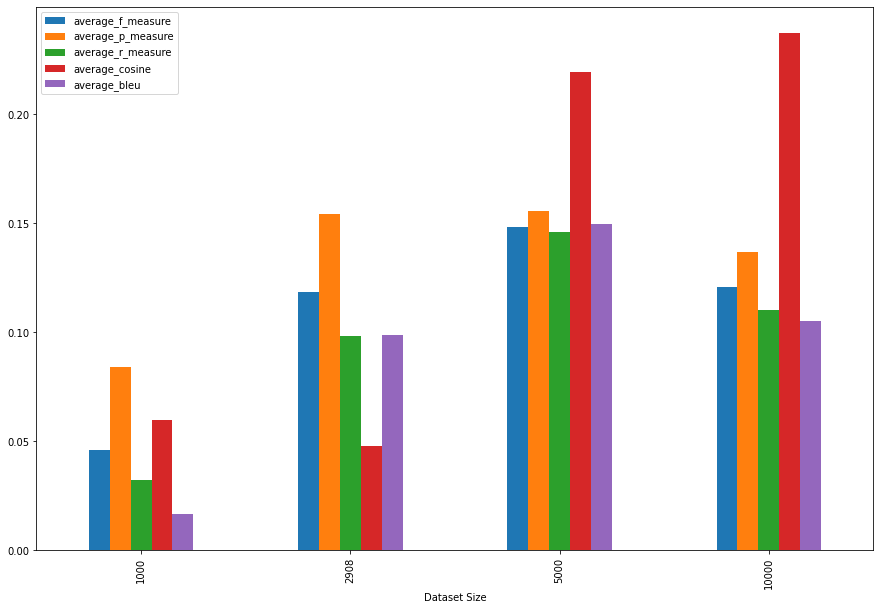

In [26]:
import matplotlib.pyplot as plot
from matplotlib.ticker import ScalarFormatter
#,figsize=(10,15)

table.plot.bar(x="Dataset Size",figsize=(15,10))
plot.show(block=True);

In [ ]:
table.plot.bar(x="Dataset Size",y="average_bleu")
plot.yscale("log")
plot.gca().yaxis.set_major_formatter(ScalarFormatter())

plot.show(block=True);